In [6]:
import numpy as np
import sep
import matplotlib.pyplot as plt
from scipy import ndimage
from scipy.ndimage import gaussian_filter
from scipy.ndimage import median_filter

from photutils.datasets import make_100gaussians_image
from photutils.background import Background2D, MedianBackground

from astropy.convolution import convolve
from photutils.segmentation import make_2dgaussian_kernel

from lvmagp.images import Image
from lvmagp.images.processors.detection import DaophotSourceDetection, SepSourceDetection
from lvmagp.focus.focusseries import ProjectionFocusSeries, PhotometryFocusSeries

from photutils.centroids import centroid_quadratic

from plotimg import plot_images


In [7]:
from plotimg import plot_images

async def focus_calc(focus, radius_data, images, source_detection):

    for idx, img in enumerate(images):
        images[idx].data = median_filter(images[idx].data, size=2)
        
        # photutils.background
        bkg_estimator = MedianBackground()
        bkg = Background2D(img.data.astype(float), (50, 50), filter_size=(3, 3),
                           bkg_estimator=bkg_estimator)
        images[idx].data = images[idx].data.astype(float) - bkg.background
        bkg_median = np.median(bkg.background)
        bkg_std = np.std(bkg.background)

        # sep.background
#        images[idx].bkg = sep.Background(images[idx].data.astype(float))
#        images[idx].data = images[idx].data.astype(float) - images[idx].bkg
#        bkg_median = np.median(images[idx].bkg)
#        bkg_std = np.std(bkg_median)
        
    for idx, img in enumerate(images):
        images[idx] = await source_detection(img)
#        images[idx].catalog.sort("fwhm")
        images[idx].catalog = images[idx].catalog[images[idx].catalog["peak"] > bkg_median + (1 * bkg_std) ]
        images[idx].catalog = images[idx].catalog[images[idx].catalog["peak"] < 65000]
#        images[idx].catalog = images[idx].catalog[images[idx].catalog["ellipticity"] < 0.3]
        images[idx].catalog.sort("flux")
        images[idx].catalog.reverse()

        sources = images[idx].catalog
        if (len(sources) > 2):
            radius = np.median(sources[column][:num_stars])
            radius_err = np.std(sources[column][:num_stars])
            radius_data[idx].append({"focus": focus, "r": radius, "rerr": radius_err})

    return bkg_median, bkg_std


In [8]:
from lvmagp.focus.curvefit import fit_hyperbola

def focus_plot(images, data):
    #print(data)

    fig, ax = plt.subplots(1, ncols=(len(data)), figsize=(8, 5/len(data)))

    for idx, dd in enumerate(data):
        focus = [d["focus"] for d in dd]
        r = [d["r"] for d in dd]
        rerr = [d["rerr"] for d in dd]

        ax_idx = ax[idx] if len(data) > 1 else ax
        ax_idx.set_title(images[idx].header["CAMNAME"])
        ax_idx.errorbar(focus, r, yerr=rerr)

        fit_focus, fit_err = fit_hyperbola(focus, r, rerr)
        print(f"focus: {fit_focus}, {fit_err}")


 focus: 34.0 exptime: 1.0 file: /data/lvm/sci/agcam/east/20221028n/lvm.sci.agcam.east_00000419.fits
 bkg_median: 31.99999999602762 bkg_std: 5.909985389191785
       peak       
------------------
  12141.4638671875
   8365.5107421875
 2144.286376953125
1103.7911376953125


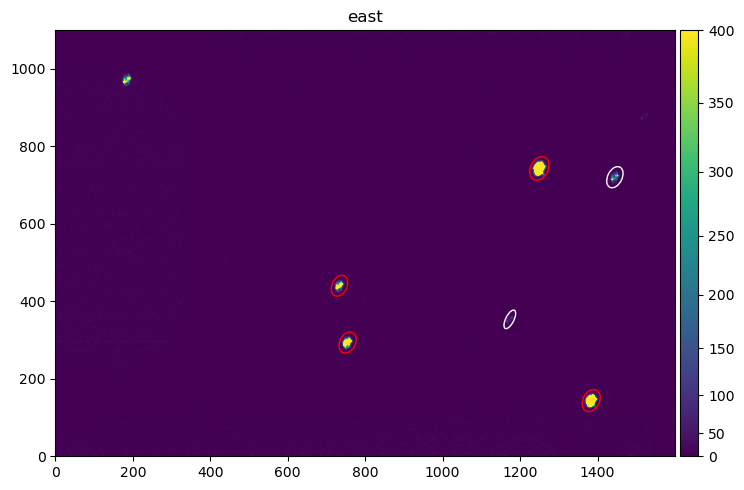

 focus: 35.0 exptime: 1.0 file: /data/lvm/sci/agcam/east/20221028n/lvm.sci.agcam.east_00000420.fits
 bkg_median: 31.999999993500218 bkg_std: 5.583091821455893
       peak       
------------------
   17231.873046875
      11567.234375
 3311.926025390625
1679.8453369140625


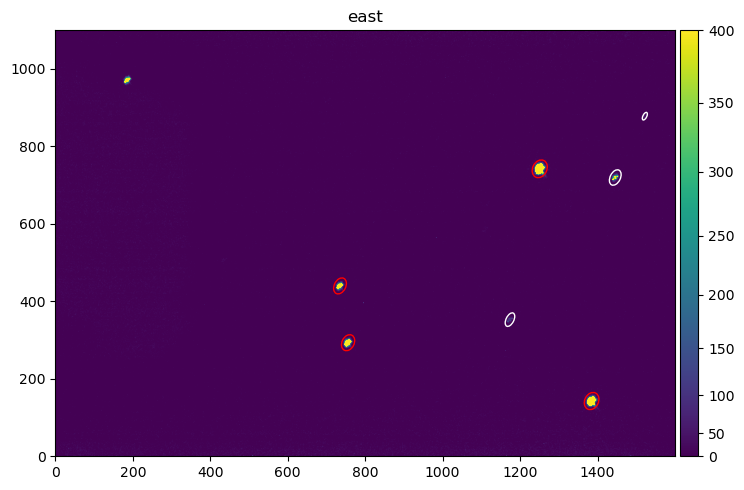

 focus: 36.0 exptime: 1.0 file: /data/lvm/sci/agcam/east/20221028n/lvm.sci.agcam.east_00000421.fits
 bkg_median: 31.999999992685837 bkg_std: 5.702605282299201
       peak      
-----------------
  21452.931640625
  15632.181640625
3968.084716796875
     2143.9765625


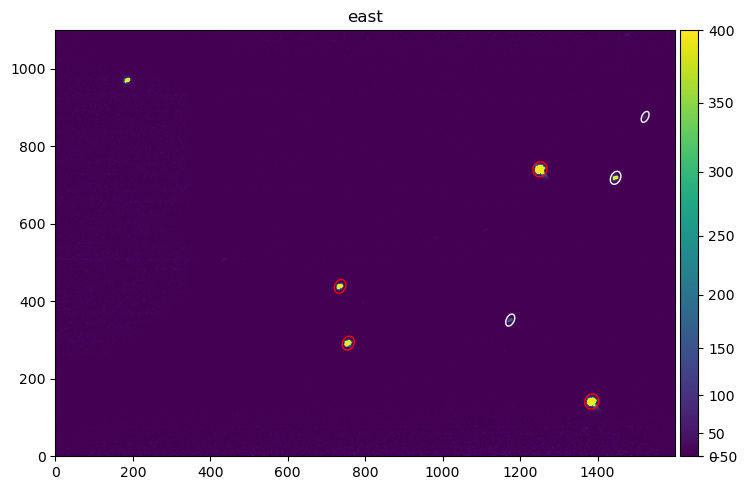

 focus: 37.0 exptime: 1.0 file: /data/lvm/sci/agcam/east/20221028n/lvm.sci.agcam.east_00000422.fits
 bkg_median: 31.999999975748956 bkg_std: 5.913684646572369
      peak      
----------------
    24110.265625
  16831.23046875
4288.83251953125
2431.80712890625


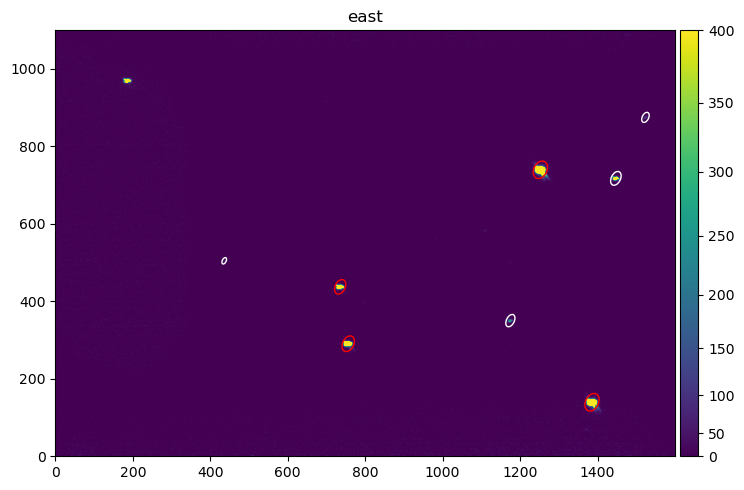

 focus: 38.0 exptime: 1.0 file: /data/lvm/sci/agcam/east/20221028n/lvm.sci.agcam.east_00000423.fits
 bkg_median: 31.999999999401886 bkg_std: 5.452771363655034
       peak      
-----------------
  30766.138671875
  20814.986328125
 5567.59521484375
3168.010498046875


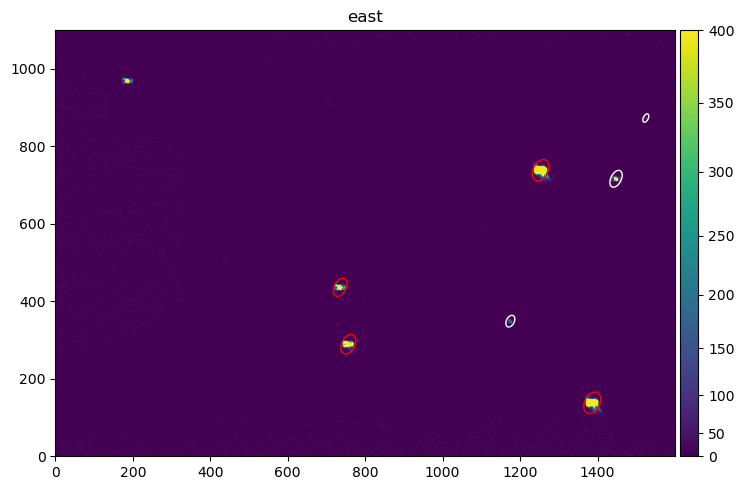

focus: 36.11692784839482, 0.002019572010090518


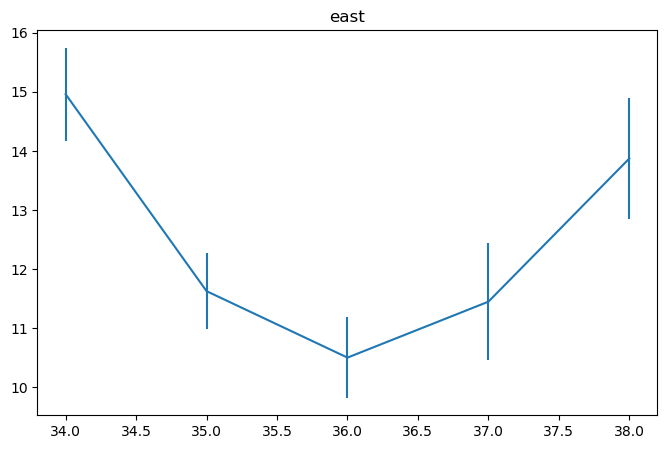

In [20]:
%matplotlib inline
#%matplotlib widget

off=400
num=15

off=404
num=5

off=391
num=7

off=392
num=5

#off=319 # to short 36 - 38, 0.5
#num=5

#off=329 #bad
#num=5

off=392
num=5

#off=365
#num=1

off=400
num=14

off=430
num=14

off=415
num=14

off=419
num=5


threshold = 3.2
minarea = 24.0
deblend_nthresh = 1.2
deblend_cont = 0.01

num_stars = 4

source_detection = SepSourceDetection(threshold=threshold, minarea=minarea, deblend_nthresh=deblend_nthresh, deblend_cont=deblend_cont)
#source_detection = SepSourceDetection()
#source_detection = DaophotSourceDetection(fwhm=4, threshold=30)

column = "fwhm"

radius_data = [[]]

fbase = lambda idx: f"/data/lvm/sci/agcam/east/20221028n/lvm.sci.agcam.east_{idx:08}.fits"

for i in range(num):
    images = [Image.from_file(fbase(i+off))]
    focus = images[0].header["FOCUSUM"]
#    print(images[0].header)
    print(f" focus: {focus} exptime: {images[0].header['EXPTIME']} file: {fbase(i+off)}")

    bkg_median, bkg_std = await focus_calc(focus, radius_data, images, source_detection)
    print(f" bkg_median: {bkg_median} bkg_std: {bkg_std}")

#    imag = await DaophotSourceDetection()(images[0])
    print(images[0].catalog[:num_stars]["peak"])
    plot_images(images, cat_max=num_stars, cat_rest=True, vmax=400)

focus_plot(images, radius_data)


In [ ]:
%matplotlib inline
#%matplotlib widget

from lvmtipo.actors import lvm

focus_guess=41.4
threshold = 12.0
minarea = 24.0
deblend_nthresh = 1.4

source_detection = SepSourceDetection(threshold= threshold, minarea=minarea, deblend_nthresh=deblend_nthresh)

num_stars = 8

await lvm.sci.pwi.start()
await lvm.sci.pwi.status()
await lvm.sci.foc.start()
await lvm.sci.foc.status()

await lvm.sci.agc.start()

radius_data = None

for focus in np.linspace(focus_guess-2.0, focus_guess+3.0, num=7):
    await lvm.sci.foc.moveAbsolute(focus, "DT")    
    filenames = (await lvm.sci.agc.expose(2.0)).flatten().unpack("*.filename")
    print(f" focus: {focus} file: {filenames}")
    images = [Image.from_file(f) for f in filenames]

    if not radius_data: radius_data = [list()]*len(images)
    await focus_calc(focus, radius_data, images, source_detection)
    plot_images(images, cat_max=num_stars, cat_rest=True, vmax=400)


focus_plot(images, radius_data)